<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Добавление-новых-признаков" data-toc-modified-id="Добавление-новых-признаков-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Добавление новых признаков</a></span></li><li><span><a href="#Лемматизация-и-очистка-текста" data-toc-modified-id="Лемматизация-и-очистка-текста-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Лемматизация и очистка текста</a></span></li><li><span><a href="#Разбивка-данных-на-выборки" data-toc-modified-id="Разбивка-данных-на-выборки-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Разбивка данных на выборки</a></span></li><li><span><a href="#Масштабированние-признаков" data-toc-modified-id="Масштабированние-признаков-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Масштабированние признаков</a></span></li><li><span><a href="#TF-IDF" data-toc-modified-id="TF-IDF-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>TF-IDF</a></span></li></ul></li><li><span><a href="#Обучение-моделей" data-toc-modified-id="Обучение-моделей-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение моделей</a></span><ul class="toc-item"><li><span><a href="#Функции" data-toc-modified-id="Функции-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Функции</a></span></li><li><span><a href="#LogisticRegression" data-toc-modified-id="LogisticRegression-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>LogisticRegression</a></span></li><li><span><a href="#CatBoostClassifier" data-toc-modified-id="CatBoostClassifier-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>CatBoostClassifier</a></span></li></ul></li><li><span><a href="#distilBERT" data-toc-modified-id="distilBERT-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>distilBERT</a></span><ul class="toc-item"><li><span><a href="#Подготовка-признаков" data-toc-modified-id="Подготовка-признаков-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Подготовка признаков</a></span></li><li><span><a href="#Разбивка-данных-на-выборки" data-toc-modified-id="Разбивка-данных-на-выборки-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Разбивка данных на выборки</a></span></li><li><span><a href="#LogisticRegression" data-toc-modified-id="LogisticRegression-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>LogisticRegression</a></span></li><li><span><a href="#CatBoostClassifier" data-toc-modified-id="CatBoostClassifier-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>CatBoostClassifier</a></span></li></ul></li><li><span><a href="#Сравнение-моделей" data-toc-modified-id="Сравнение-моделей-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Сравнение моделей</a></span></li><li><span><a href="#Тестирование-лучшей-модели" data-toc-modified-id="Тестирование-лучшей-модели-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Тестирование лучшей модели</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Выводы</a></span></li></ul></div>

# Проект для «Викишоп» с BERT

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Нужно обучить модель классифицировать комментарии на позитивные и негативные. В качестве исходных данных - набор данных с разметкой о токсичности правок.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from catboost import CatBoostClassifier
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, \
        f1_score, accuracy_score, roc_auc_score, roc_curve, \
        precision_score, recall_score
from sklearn.preprocessing import StandardScaler

import re
import nltk
from nltk.corpus import stopwords as nltk_stopwords
from string import punctuation
from sklearn.feature_extraction.text import TfidfVectorizer

from scipy.sparse import hstack, vstack, csc_matrix, csr_matrix, coo_matrix

import torch
from tokenizers import Tokenizer
import transformers as ppb
from tqdm import tqdm, notebook
tqdm.pandas()

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('./datasets/toxic_comments.csv', index_col=0) 

In [3]:
df.head().style.set_properties(subset=['text'],**{'text-align': 'left'})

,text,toxic
0,"Explanation Why the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",0
1,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, January 11, 2016 (UTC)",0
2,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.",0
3,""" More I can't make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of """"types of accidents"""" -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no-one else does first - if you have any preferences for formatting style on references or want to do it yourself please let me know. There appears to be a backlog on articles for review so I guess there may be a delay until a reviewer turns up. It's listed in the relevant form eg Wikipedia:Good_article_nominations#Transport """,0
4,"You, sir, are my hero. Any chance you remember what page that's on?",0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


Изменим порядок столбцов, для удобства

In [5]:
df = df[['toxic', 'text']] 

Посмотрим на распределение классов в данных

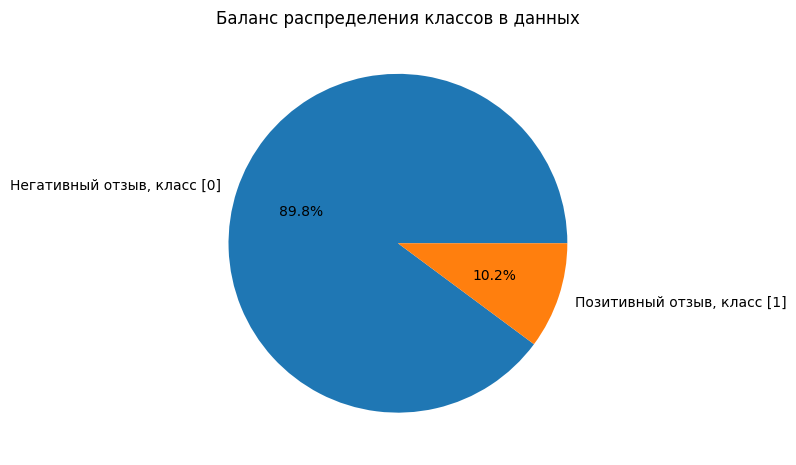

In [6]:
df['toxic'].value_counts(normalize=True).plot(kind='pie',
            figsize=[5.5,5.5], legend=False, autopct='%1.1f%%',
            labels=['Негативный отзыв, класс [0]','Позитивный отзыв, класс [1]'])
plt.title('Баланс распределения классов в данных')
plt.ylabel('')
plt.show()

* Наблюдается сильный дисбаланс классов, соотношение 1 к 9

### Добавление новых признаков

Функция для создания новых признаков

In [7]:
def feature(df, text_columns):
    df_new = pd.DataFrame(index=df.index)
    df_new['word_count'] = df[text_columns].apply(lambda x : len(x.split()))
    df_new['char_count'] = df[text_columns].apply(lambda x : len(x.replace(" ","")))
    df_new['punc_count'] = df[text_columns].apply(lambda x : len([i for i in x if i in punctuation]))
    df_new['total_length'] = df[text_columns].apply(len)
    df_new['capitals'] = df[text_columns].apply(lambda x: sum(1 for i in x if i.isupper()))
    df_new['caps_vs_length'] = df_new.apply(lambda row: float(row['capitals'])/float(row['total_length']), axis=1)
    df_new['num_exclamation_marks'] =df[text_columns].apply(lambda x: x.count('!'))
    df_new['num_question_marks'] = df[text_columns].apply(lambda x: x.count('?'))
    df_new['num_punctuation'] = df[text_columns].apply(lambda x: sum(x.count(w) for w in '.,;:'))
    df_new['num_symbols'] = df[text_columns].apply(lambda x: sum(x.count(w) for w in '*&$%'))
    df_new['num_unique_words'] = df[text_columns].apply(lambda x: len(set(w for w in x.split())))
    return df_new

In [8]:
features_new = feature(df, 'text')

Статистические данные новых признаков:

In [9]:
features_new.describe()

,word_count,char_count,punc_count,total_length,capitals,caps_vs_length,num_exclamation_marks,num_question_marks,num_punctuation,num_symbols,num_unique_words
count,159292.000000,159292.000000,159292.000000,159292.000000,159292.000000,159292.000000,159292.000000,159292.000000,159292.000000,159292.000000,159292.000000
mean,67.213545,326.883955,15.867809,393.691303,17.148620,0.051619,0.661653,0.449043,7.966094,0.116465,48.059633
std,99.133908,491.703226,36.638691,590.111825,96.593201,0.092817,25.921868,1.590390,12.760427,1.087693,54.389936
min,1.000000,3.000000,0.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,17.000000,80.000000,4.000000,95.000000,3.000000,0.020706,0.000000,0.000000,2.000000,0.000000,16.000000
50%,36.000000,170.000000,8.000000,205.000000,7.000000,0.031746,0.000000,0.000000,4.000000,0.000000,31.000000
75%,75.000000,361.000000,17.000000,435.000000,15.000000,0.048825,0.000000,1.000000,9.000000,0.000000,59.000000
max,1411.000000,4967.000000,4942.000000,5000.000000,4960.000000,0.998189,4942.000000,209.000000,682.000000,148.000000,816.000000


Добавим новые признаки в исходный датафрейм

In [10]:
df = pd.concat([df, features_new], axis=1)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159292 entries, 0 to 159450
Data columns (total 13 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   toxic                  159292 non-null  int64  
 1   text                   159292 non-null  object 
 2   word_count             159292 non-null  int64  
 3   char_count             159292 non-null  int64  
 4   punc_count             159292 non-null  int64  
 5   total_length           159292 non-null  int64  
 6   capitals               159292 non-null  int64  
 7   caps_vs_length         159292 non-null  float64
 8   num_exclamation_marks  159292 non-null  int64  
 9   num_question_marks     159292 non-null  int64  
 10  num_punctuation        159292 non-null  int64  
 11  num_symbols            159292 non-null  int64  
 12  num_unique_words       159292 non-null  int64  
dtypes: float64(1), int64(11), object(1)
memory usage: 17.0+ MB


Проверим данные на пропуски

In [12]:
df.isna().mean()

toxic                    0.0
text                     0.0
word_count               0.0
char_count               0.0
punc_count               0.0
total_length             0.0
capitals                 0.0
caps_vs_length           0.0
num_exclamation_marks    0.0
num_question_marks       0.0
num_punctuation          0.0
num_symbols              0.0
num_unique_words         0.0
dtype: float64

* Пропусков не обнаруженно

### Лемматизация и очистка текста

In [13]:
wnl = nltk.WordNetLemmatizer()

Функция очистки текста

In [14]:
def clear(text):
    return re.sub(r"[^'a-zA-Z ]", ' ', text)

Функция лемматизации

In [15]:
def lemm(text):
    s = text
    s = " ".join(nltk.word_tokenize(s))
    s = wnl.lemmatize(s).lower()
    return s

In [16]:
df['text'] = df['text'].progress_apply(lambda x: clear(x))
df['lemma'] = df['text'].progress_apply(lambda x: lemm(x))

100%|██████████| 159292/159292 [00:32<00:00, 4863.61it/s]


Проверим результат лемматизации

In [17]:
df[['text', 'lemma']].head().style.set_properties(**{'text-align':'left'})

,text,lemma
0,Explanation Why the edits made under my username Hardcore Metallica Fan were reverted They weren't vandalisms just closure on some GAs after I voted at New York Dolls FAC And please don't remove the template from the talk page since I'm retired now,explanation why the edits made under my username hardcore metallica fan were reverted they were n't vandalisms just closure on some gas after i voted at new york dolls fac and please do n't remove the template from the talk page since i 'm retired now
1,D'aww He matches this background colour I'm seemingly stuck with Thanks talk January UTC,d'aww he matches this background colour i 'm seemingly stuck with thanks talk january utc
2,Hey man I'm really not trying to edit war It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page He seems to care more about the formatting than the actual info,hey man i 'm really not trying to edit war it 's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page he seems to care more about the formatting than the actual info
3,More I can't make any real suggestions on improvement I wondered if the section statistics should be later on or a subsection of types of accidents I think the references may need tidying so that they are all in the exact same format ie date format etc I can do that later on if no one else does first if you have any preferences for formatting style on references or want to do it yourself please let me know There appears to be a backlog on articles for review so I guess there may be a delay until a reviewer turns up It's listed in the relevant form eg Wikipedia Good article nominations Transport,more i ca n't make any real suggestions on improvement i wondered if the section statistics should be later on or a subsection of types of accidents i think the references may need tidying so that they are all in the exact same format ie date format etc i can do that later on if no one else does first if you have any preferences for formatting style on references or want to do it yourself please let me know there appears to be a backlog on articles for review so i guess there may be a delay until a reviewer turns up it 's listed in the relevant form eg wikipedia good article nominations transport
4,You sir are my hero Any chance you remember what page that's on,you sir are my hero any chance you remember what page that 's on


Поменяем расположение столбца `lemma` для удобства

In [18]:
df.insert(2, "lemma", df.pop("lemma"))

### Разбивка данных на выборки

In [19]:
X = df.drop('toxic', axis=1)
y = df['toxic']

In [20]:
X_train, X_test, y_train, y_test  = train_test_split(X, y,
            test_size=0.3, shuffle=True, random_state=56, stratify=y)

In [21]:
print(f'Итоговые размеры выборок, обучающая:тестовая - {y_train.count() / y.count():.0%}'
      f':{y_test.count()/ y.count():.0%}')

Итоговые размеры выборок, обучающая:тестовая - 70%:30%


### Масштабированние признаков

In [22]:
scaler = StandardScaler().fit(X_train.iloc[:, 2:])

In [23]:
def scaler_trsnsform(df, scaler=scaler):
    return pd.DataFrame(scaler.transform(df),
                        columns=df.columns,
                        index=df.index)

In [24]:
X_train.iloc[:, 2:] = scaler_trsnsform(X_train.iloc[:, 2:], scaler)
X_test.iloc[:, 2:] = scaler_trsnsform(X_test.iloc[:, 2:], scaler)

Оптимизуруем типы данных

In [25]:
for i in X_train.columns[2:]:
    X_train[i] = pd.to_numeric(X_train[i], downcast='float')
    X_test[i] = pd.to_numeric(X_test[i], downcast='float')

### TF-IDF

In [26]:
corpus_train = X_train['lemma']
corpus_test = X_test['lemma']

In [27]:
stopwords = set(nltk_stopwords.words('english'))
model_tfidf = TfidfVectorizer(stop_words=stopwords)
model_tfidf.fit(corpus_train)

TfidfVectorizer(stop_words={'a', 'about', 'above', 'after', 'again', 'against',
                            'ain', 'all', 'am', 'an', 'and', 'any', 'are',
                            'aren', "aren't", 'as', 'at', 'be', 'because',
                            'been', 'before', 'being', 'below', 'between',
                            'both', 'but', 'by', 'can', 'couldn', "couldn't", ...})

In [28]:
tfidf_train = model_tfidf.transform(corpus_train)
tfidf_test = model_tfidf.transform(corpus_test)

Объединение признаков

In [29]:
X_train_full = csr_matrix(hstack((csr_matrix(X_train.iloc[:, 2:]), tfidf_train)))
X_test_full = csr_matrix(hstack((csr_matrix(X_test.iloc[:, 2:]), tfidf_test)))

In [30]:
X_train_full.shape, X_test_full.shape, X_train_full.shape[0] + X_test_full.shape[0]

((111504, 136903), (47788, 136903), 159292)

## Обучение моделей

In [31]:
table_results = pd.DataFrame(columns=['Name', 'Best result'])

### Функции

In [32]:
class style:
    BOLD = '\033[1m'
    END = '\033[0m'

Функция для вывода результатов модели логистической регрессии на тренировочных данных и записи из сводную таблицу

In [33]:
def result_lgrsv(model, table=None, name=None):
    print(f'{style.BOLD}'
          f'Результаты модели на тренировочных данных\n\n'
          f'{style.END}'
          f'Лучший коэфициент регуляризации: {model.C_[0]}\n'
          f'Лучший результат модели: {model.scores_[1].max():.4f}') 
    
    # Запишем результаты в таблицу
    if name:
        return table.append({'Name':name,
                              'Best result':round(model.scores_[1].max(), 4)},
                             ignore_index=True)

Функция для вывода результатов модели на тренировочных данных и записи из сводную таблицу, GridSerchCV

In [34]:
def result_grid(model, table=None, name=None):
    print(f'{style.BOLD}'
          f'Результаты модели на тренировочных данных\n\n'
          f'{style.END}'
          f'Лучший гиперпараметры: {model.best_params_}\n'
          f'Лучший результат модели: {model.best_score_:.4f}') 
    
    # Запишем результаты в таблицу
    if name:
        return table.append({'Name':name,
                              'Best result':round(model.best_score_, 4)},
                             ignore_index=True)

Функция для вывода результатов модели на тeстовых данных

In [35]:
def test_result(model, X, y):
    
    # Выведем результаты
    print(style.BOLD + 'Результаты на тестовых данных:' + style.END)
    print()
    predict = model.predict(X)
    probabilities_one = model.predict_proba(X)[:, 1]
    score = round(accuracy_score(y, predict), 4)
    f1 = round(f1_score(y, predict), 4)
    precision = round(precision_score(y, predict), 4)
    recall = round(recall_score(y, predict), 4)
    roc_auc = round(roc_auc_score(y, probabilities_one), 4)
    print(f'Значение F1-меры: {f1}')
    print(f'Точность данных (precision): {precision}')
    print(f'Полнота данных (recall): {recall}')
    print(f'Значение ROC-AUC: {roc_auc}')
    print(f'Доля правильных ответов: {score}')
    
    # Построим ROC-кривую
    print()
    print(style.BOLD + 'ROC-кривая:' + style.END)
    fpr, tpr, thresholds = roc_curve(y, probabilities_one)
    plt.figure(figsize=(6, 6))
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], linestyle='--') # ROC-кривая случайной модели
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.show()
    
    # Посмотрим матрицу ошибок
    print()
    print(style.BOLD + 'Матрица ошибок:' + style.END)
    fig, ax = plt.subplots(figsize=(10,8))
    ConfusionMatrixDisplay.from_predictions(y, predict, ax=ax,
             display_labels=['Негативный отзыв [0]','Позитивный отзыв[1]'])
    ax.set(xlabel='Predicted', ylabel='Actual')
    plt.show()
    print(classification_report(y, predict,
          target_names=['Негативный отзыв [0]','Позитивный отзыв[1]']))

### LogisticRegression

In [36]:
C = [25, 27, 30, 32, 35]

In [37]:
%%time
clf = LogisticRegressionCV(Cs = C, cv=3, scoring = 'f1',
                           class_weight='balansed', max_iter=5000,
                           random_state=12345, n_jobs=-1)
clf.fit(X_train_full, y_train)

CPU times: total: 3min 47s
Wall time: 1min 48s


LogisticRegressionCV(Cs=[25, 27, 30, 32, 35], class_weight='balansed', cv=3,
                     max_iter=5000, n_jobs=-1, random_state=12345,
                     scoring='f1')

In [38]:
table_results = result_lgrsv(clf, table_results, 'LogisticRegression')

Результаты модели на тренировочных данных

Лучший коэфициент регуляризации: 27
Лучший результат модели: 0.7751


### CatBoostClassifier

In [39]:
cat = CatBoostClassifier(random_state=56, metric_period=5,
                         eval_metric='F1')

In [40]:
cat_params = {'learning_rate': [1],
              'iterations': [300],
              'depth': [4]}

In [41]:
%%time
cat_grid = GridSearchCV(estimator=cat, param_grid=cat_params,
                        cv=3, scoring='f1', n_jobs=-1, verbose=3)
cat_grid.fit(X_train_full, y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
0:	learn: 0.4100174	total: 450ms	remaining: 2m 14s
5:	learn: 0.6437365	total: 2.05s	remaining: 1m 40s
10:	learn: 0.6900418	total: 3.58s	remaining: 1m 34s
15:	learn: 0.7181289	total: 5.08s	remaining: 1m 30s
20:	learn: 0.7337900	total: 6.6s	remaining: 1m 27s
25:	learn: 0.7477977	total: 8.09s	remaining: 1m 25s
30:	learn: 0.7564699	total: 9.58s	remaining: 1m 23s
35:	learn: 0.7638903	total: 11.1s	remaining: 1m 21s
40:	learn: 0.7695535	total: 12.6s	remaining: 1m 19s
45:	learn: 0.7741550	total: 14.1s	remaining: 1m 18s
50:	learn: 0.7806901	total: 15.7s	remaining: 1m 16s
55:	learn: 0.7850007	total: 17.2s	remaining: 1m 14s
60:	learn: 0.7887296	total: 18.7s	remaining: 1m 13s
65:	learn: 0.7929330	total: 20.2s	remaining: 1m 11s
70:	learn: 0.7956905	total: 21.7s	remaining: 1m 10s
75:	learn: 0.7986378	total: 23.2s	remaining: 1m 8s
80:	learn: 0.8021172	total: 24.8s	remaining: 1m 6s
85:	learn: 0.8035498	total: 26.2s	remaining: 1m 5s
90:	learn: 

GridSearchCV(cv=3,
             estimator=<catboost.core.CatBoostClassifier object at 0x0000022744F8ED60>,
             n_jobs=-1,
             param_grid={'depth': [4], 'iterations': [300],
                         'learning_rate': [1]},
             scoring='f1', verbose=3)

In [42]:
table_results = result_grid(cat_grid, table_results, 'CatBoost')

Результаты модели на тренировочных данных

Лучший гиперпараметры: {'depth': 4, 'iterations': 300, 'learning_rate': 1}
Лучший результат модели: 0.7525


## distilBERT

### Подготовка признаков

Загрузка предобученной модели и токенизатора 

In [43]:
model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_projector.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [44]:
tokenized = df.text.progress_apply(
    lambda x: tokenizer.encode(x, add_special_tokens=True))

100%|██████████| 159292/159292 [03:40<00:00, 723.26it/s]


In [45]:
df['tokenized'] = tokenized
df['len'] = pd.DataFrame([len(i) for i in tokenized.values], index=df.index).iloc[:, 0]

In [46]:
df['len'].describe()

count    159292.000000
mean         78.526630
std         115.356548
min           2.000000
25%          21.000000
50%          43.000000
75%          87.000000
max        2502.000000
Name: len, dtype: float64

In [47]:
def hist_box(df, col, binwidth=1):
    fig,ax = plt.subplots(2,1,sharex=True,figsize=(12,8),gridspec_kw={'height_ratios': [4, 1]})

    sns.histplot(data=df,x=col,
                 binwidth=binwidth,
                 ax=ax[0])

    sns.boxplot(data=df,x=col,ax=ax[1])
    return fig,ax

(<Figure size 1200x800 with 2 Axes>,
 array([<AxesSubplot:xlabel='len', ylabel='Count'>,
        <AxesSubplot:xlabel='len'>], dtype=object))

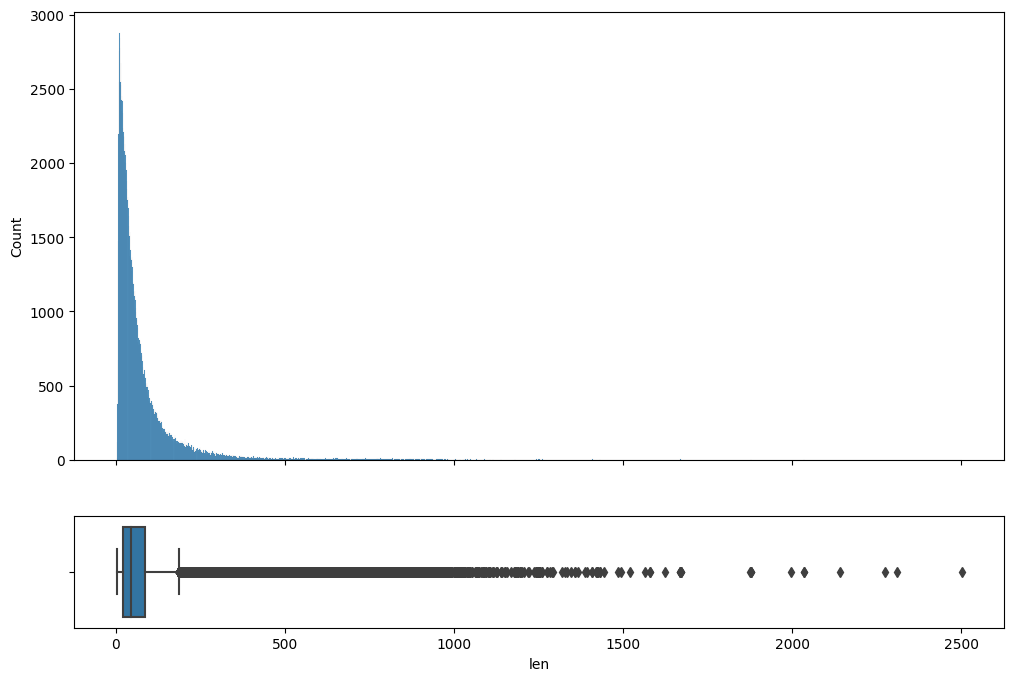

In [48]:
hist_box(df, 'len')

* Видно, что кол-во токенов очень сильно различается, минимально значение равно 2, средние 78, а максимальное 2502. Большинство строк имеет кол-во токенов менее 100, напишем фукцию для оптимизации работы BERT модели

Запишем необходимые нам ячейки в новый датафрейм

In [49]:
df_bert = df[['toxic', 'tokenized', 'len']].copy()

Склеим созданные новые признаки с новым датафреймом и отсортируем датафрем по кол-ву токенов

In [50]:
new_fetures = X_train.iloc[:, 2:].append(X_test.iloc[:, 2:]).sort_index()
df_bert = pd.concat([df_bert, new_fetures], axis=1)
df_bert = df_bert.sort_values('len', ignore_index=True)

In [51]:
df_bert.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   toxic                  159292 non-null  int64  
 1   tokenized              159292 non-null  object 
 2   len                    159292 non-null  int64  
 3   word_count             159292 non-null  float32
 4   char_count             159292 non-null  float32
 5   punc_count             159292 non-null  float32
 6   total_length           159292 non-null  float32
 7   capitals               159292 non-null  float32
 8   caps_vs_length         159292 non-null  float32
 9   num_exclamation_marks  159292 non-null  float32
 10  num_question_marks     159292 non-null  float32
 11  num_punctuation        159292 non-null  float32
 12  num_symbols            159292 non-null  float32
 13  num_unique_words       159292 non-null  float32
dtypes: float32(11), int64(2), object(1)


Функция для оптимизации работы модели BERT

In [52]:
def bert_batch(tokens, i, batch_size):
    if batch_size*(i+1) <= tokens.shape[0]:
        if len(tokens[batch_size*(i+1)-1]) < 512:
            l = len(tokens[batch_size*(i+1)-1]) 
        else:
            l = 512
        lst = tokens[batch_size*i:batch_size*(i+1)]
        padded = np.array([i[:l] + [0]*(l - len(i)) for i in lst])
        attention_mask = np.where(padded != 0, 1, 0)
        batch = torch.IntTensor(padded) 
        attention_mask_batch = torch.ShortTensor(attention_mask)
    else:
        if len(tokens.iloc[-1]) < 512:
            l = len(tokens.iloc[-1]) 
        else:
            l = 512
        lst = tokens[batch_size*i:]
        padded = np.array([i[:l] + [0]*(l - len(i)) for i in lst])
        attention_mask = np.where(padded != 0, 1, 0)
        batch = torch.IntTensor(padded) 
        attention_mask_batch = torch.ShortTensor(attention_mask)

    with torch.no_grad():
        batch_embeddings = model(batch, attention_mask=attention_mask_batch)
    
    return pd.DataFrame(batch_embeddings[0][:,0,:].numpy(), index=lst.index)

In [53]:
batch_size = 300
date_bert = pd.DataFrame()
for i in notebook.tqdm(range(df_bert.shape[0] // batch_size+1)):
    date_bert = date_bert.append(bert_batch(df_bert['tokenized'], i, batch_size))

  0%|          | 0/531 [00:00<?, ?it/s]

Добавим к нашим данным, созданные признаки моделью BERT и удалим ненужные столбцы

In [54]:
date = pd.concat([df_bert, date_bert], axis=1)
date = date.drop(['tokenized', 'len'], axis=1)

In [55]:
date.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Columns: 780 entries, toxic to 767
dtypes: float32(779), int64(1)
memory usage: 474.6 MB


In [56]:
date.head()

,toxic,word_count,char_count,punc_count,total_length,capitals,caps_vs_length,num_exclamation_marks,num_question_marks,num_punctuation,...,758,759,760,761,762,763,764,765,766,767
0,1,-0.670296,-0.659850,-0.325628,-0.660106,-0.18381,-0.556986,-0.02397,-0.272633,-0.627299,...,0.072798,0.023225,0.068635,-0.076926,0.118267,-0.121892,-0.053214,-0.071568,0.132806,0.221732
1,0,-0.670296,-0.637401,-0.300310,-0.644794,-0.18381,-0.556986,-0.02397,-0.272633,-0.390102,...,0.072798,0.023225,0.068635,-0.076926,0.118267,-0.121892,-0.053214,-0.071568,0.132806,0.221732
2,0,-0.660154,-0.631278,-0.300310,-0.637989,-0.18381,-0.556986,-0.02397,-0.272633,-0.390102,...,0.072798,0.023225,0.068635,-0.076926,0.118267,-0.121892,-0.053214,-0.071568,0.132806,0.221732
3,0,-0.650013,-0.627196,-0.274992,-0.631184,-0.18381,-0.556986,-0.02397,-0.272633,-0.390102,...,0.072798,0.023225,0.068635,-0.076926,0.118267,-0.121892,-0.053214,-0.071568,0.132806,0.221732
4,0,-0.660154,-0.655768,-0.274992,-0.658404,-0.18381,-0.556986,-0.02397,-0.272633,-0.627299,...,0.072798,0.023225,0.068635,-0.076926,0.118267,-0.121892,-0.053214,-0.071568,0.132806,0.221732


### Разбивка данных на выборки

In [57]:
X_bert = date.drop('toxic', axis=1)
y_bert = date['toxic']

In [58]:
X_train_bert, X_test_bert, y_train_bert, y_test_bert  = train_test_split(
              X_bert, y_bert, test_size=0.3, shuffle=True,
              random_state=56, stratify=y_bert)

In [59]:
print(f'Итоговые размеры выборок, обучающая:тестовая - '
      f'{y_train_bert.count() / y_bert.count():.0%}'
      f':{y_test_bert.count()/ y_bert.count():.0%}')

Итоговые размеры выборок, обучающая:тестовая - 70%:30%


### LogisticRegression

In [60]:
C = [13, 15, 17, 20]

In [61]:
%%time
clf = LogisticRegressionCV(Cs = C, cv=3, scoring = 'f1',
                           class_weight='balansed', max_iter=5000,
                           random_state=56, n_jobs=-1)
clf.fit(X_train_bert.values, y_train_bert.values)

CPU times: total: 29.6 s
Wall time: 2min 31s


LogisticRegressionCV(Cs=[13, 15, 17, 20], class_weight='balansed', cv=3,
                     max_iter=5000, n_jobs=-1, random_state=56, scoring='f1')

In [62]:
table_results = result_lgrsv(clf, table_results, 'BERT_LogisticRegression')

Результаты модели на тренировочных данных

Лучший коэфициент регуляризации: 15
Лучший результат модели: 0.7485


### CatBoostClassifier

In [63]:
cat = CatBoostClassifier(iterations=300, 
         random_state=56, metric_period=25,
         eval_metric='F1', auto_class_weights= 'Balanced')

In [64]:
cat_params = {'learning_rate': [0.25],
              'iterations': [2000],
              'depth': [4]}

In [65]:
%%time
cat_grid = GridSearchCV(estimator=cat, param_grid=cat_params,
                        cv=3, scoring='f1', n_jobs=-1, verbose=3)
cat_grid.fit(X_train_bert, y_train_bert)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
0:	learn: 0.7948969	total: 72.1ms	remaining: 2m 24s
25:	learn: 0.8773680	total: 1.61s	remaining: 2m 2s
50:	learn: 0.8895440	total: 2.99s	remaining: 1m 54s
75:	learn: 0.8990779	total: 4.36s	remaining: 1m 50s
100:	learn: 0.9059631	total: 5.72s	remaining: 1m 47s
125:	learn: 0.9119311	total: 7.1s	remaining: 1m 45s
150:	learn: 0.9164819	total: 8.44s	remaining: 1m 43s
175:	learn: 0.9215027	total: 9.8s	remaining: 1m 41s
200:	learn: 0.9265832	total: 11.2s	remaining: 1m 40s
225:	learn: 0.9303801	total: 12.5s	remaining: 1m 38s
250:	learn: 0.9353870	total: 13.9s	remaining: 1m 36s
275:	learn: 0.9390679	total: 15.2s	remaining: 1m 34s
300:	learn: 0.9427805	total: 16.5s	remaining: 1m 33s
325:	learn: 0.9471290	total: 17.9s	remaining: 1m 31s
350:	learn: 0.9511093	total: 19.2s	remaining: 1m 30s
375:	learn: 0.9542748	total: 20.6s	remaining: 1m 28s
400:	learn: 0.9572241	total: 21.9s	remaining: 1m 27s
425:	learn: 0.9600537	total: 23.3s	remaining: 1

GridSearchCV(cv=3,
             estimator=<catboost.core.CatBoostClassifier object at 0x0000022771655E20>,
             n_jobs=-1,
             param_grid={'depth': [4], 'iterations': [2000],
                         'learning_rate': [0.25]},
             scoring='f1', verbose=3)

In [66]:
table_results = result_grid(cat_grid, table_results, 'BERT_CatBoost')

Результаты модели на тренировочных данных

Лучший гиперпараметры: {'depth': 4, 'iterations': 2000, 'learning_rate': 0.25}
Лучший результат модели: 0.7344


## Сравнение моделей

In [67]:
table_results

,Name,Best result
0,LogisticRegression,0.7751
1,CatBoost,0.7525
2,BERT_LogisticRegression,0.7485
3,BERT_CatBoost,0.7344


***Выводы***
* Лучшие результаты показала модель логистической регрессии на признаках полученных с помощью TF-IDF, значение метрики F1=0.7751, что выше необходимого результата 0.75
* Модели обученные с использование BERT показали более плохие результаты, это может быть связано с ограничением кол-ва токенов - 512

## Тестирование лучшей модели

In [68]:
%%time
clf = LogisticRegression(C = 30, class_weight='balansed',
                         max_iter=5000, random_state=56, n_jobs=-1)
clf.fit(X_train_full, y_train)

CPU times: total: 93.8 ms
Wall time: 31.9 s


LogisticRegression(C=30, class_weight='balansed', max_iter=5000, n_jobs=-1,
                   random_state=56)

Результаты на тестовых данных:

Значение F1-меры: 0.7791
Точность данных (precision): 0.8556
Полнота данных (recall): 0.7152
Значение ROC-AUC: 0.9662
Доля правильных ответов: 0.9588

ROC-кривая:


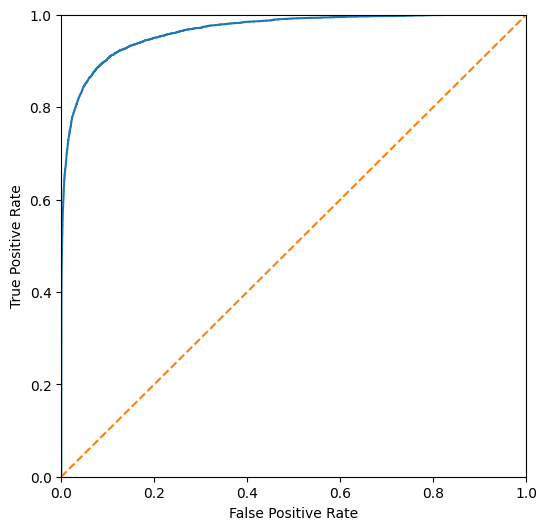


Матрица ошибок:


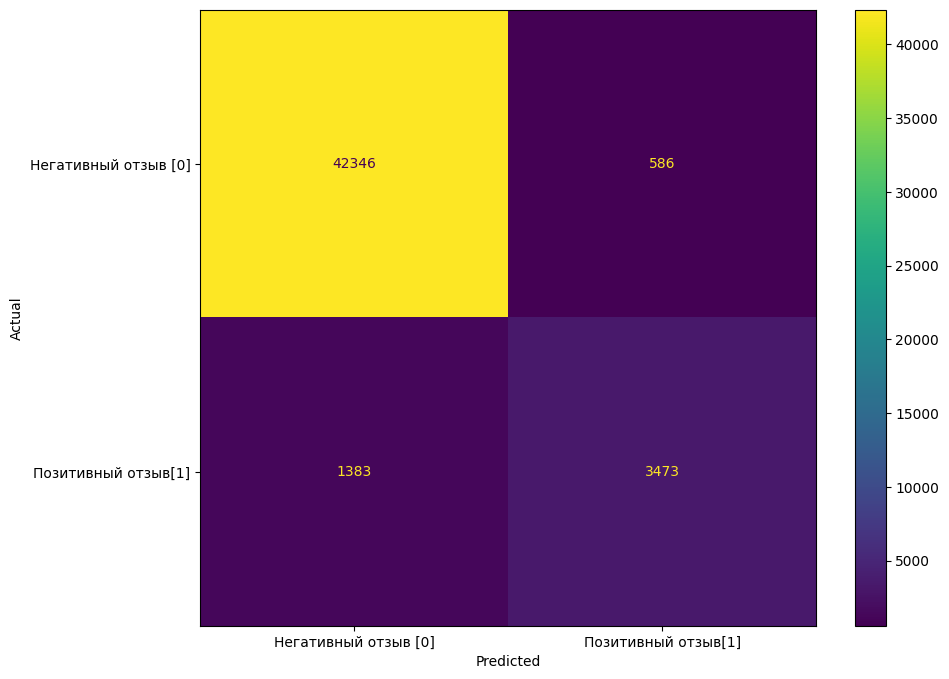

                      precision    recall  f1-score   support

Негативный отзыв [0]       0.97      0.99      0.98     42932
 Позитивный отзыв[1]       0.86      0.72      0.78      4856

            accuracy                           0.96     47788
           macro avg       0.91      0.85      0.88     47788
        weighted avg       0.96      0.96      0.96     47788



In [69]:
test_result(clf, X_test_full, y_test)

## Выводы

* Лучшие результаты показала модель логистической регрессии на признаках полученных с помощью TF-IDF, значение метрики F1 на тестовых данных - 0.7791, что выше необходимого результата 0.75
* Модели обученные с использование BERT показали более плохие результаты, это может быть связано с ограничением кол-ва токенов - 512